### Preparing the Data

In [241]:
import requests
import json

url = 'https://api.thevirustracker.com/free-api?countryTimeline=EG'

x = requests.post(url) 

#print (x.content)
Data= json.loads(x.content)['timelineitems'][0]
 

In [242]:
import pandas as pd
import numpy as np

data= pd.DataFrame(Data)
data

,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/01/20,3/02/20,3/03/20,3/04/20,3/05/20,3/06/20,3/07/20,3/08/20,3/09/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,...,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/01/20,7/02/20,7/03/20,7/04/20,7/05/20,7/06/20,7/07/20,7/08/20,7/09/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,stat
new_daily_cases,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,12,0,34,6,4,1,7,13,29,1,40,46,0,60,29,9,33,39,36,...,1455,1442,1577,1677,1618,1691,1567,1363,1218,1774,1547,1475,1576,1332,1420,1569,1625,1168,1265,1566,1557,1503,1485,1412,1324,1218,969,1057,1025,950,981,923,912,931,929,913,928,703,698,ok
new_daily_deaths,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,2,2,0,2,2,4,5,1,...,36,35,45,62,91,97,94,84,88,79,89,87,85,87,85,83,87,88,81,83,81,81,86,81,79,63,79,67,75,53,85,67,89,77,73,59,53,68,63,ok
total_cases,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,15,15,49,55,59,60,67,80,109,110,150,196,196,256,285,294,327,366,402,...,38284,39726,41303,42980,44598,46289,47856,49219,50437,52211,53758,55233,56809,58141,59561,61130,62755,63923,65188,66754,68311,69814,71299,72711,74035,75253,76222,77279,78304,79254,80235,81158,82070,83001,83930,84843,85771,86474,87172,ok
total_recoveries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,27,27,27,27,21,27,32,32,32,39,41,56,56,80,...,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,21718,21718,21718,21718,21718,21718,21718,21718,21718,21718,21718,21718,ok
total_deaths,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,4,6,6,8,10,14,19,20,...,1342,1377,1422,1484,1575,1672,1766,1850,1938,2017,2106,2193,2278,2365,2450,2533,2620,2708,2789,2872,2953,3034,3120,3201,3280,3343,3422,3489,3564,3617,3702,3769,3858,3935,4008,4067,4120,4188,4251,ok


In [244]:
data= pd.DataFrame(Data)
series = data.iloc[0].to_numpy()
series = series[:-1]
series = series.astype('float32')
mean= np.mean(series)
var= np.var(series)
series = ((series - mean)/var)*1000
series

array([-1.6769176 , -1.6799239 , -1.6799239 , -1.6799239 , -1.6799239 ,
       -1.6799239 , -1.6799239 , -1.6799239 , -1.6799239 , -1.6799239 ,
       -1.6799239 , -1.6799239 , -1.6799239 , -1.6799239 , -1.6799239 ,
       -1.6799239 , -1.6769176 , -1.6799239 , -1.6799239 , -1.6799239 ,
       -1.6769176 , -1.643848  , -1.6799239 , -1.5777085 , -1.6618859 ,
       -1.6678985 , -1.6769176 , -1.6588795 , -1.6408415 , -1.5927402 ,
       -1.6769176 , -1.5596706 , -1.5416324 , -1.6799239 , -1.4995439 ,
       -1.5927402 , -1.6528668 , -1.5807148 , -1.5626769 , -1.5716959 ,
       -1.5175818 , -1.5626769 , -1.5566642 , -1.5596706 , -1.5807148 ,
       -1.5386262 , -1.5175818 , -1.4724869 , -1.4213792 , -1.3191638 ,
       -1.4243854 , -1.3702714 , -1.2319802 , -1.2951131 , -1.3492272 ,
       -1.2620435 , -1.3943222 , -1.2440056 , -1.3011259 , -1.3041322 ,
       -1.1989104 , -1.2139422 , -1.1748598 , -1.1658407 , -1.1147332 ,
       -1.3432145 , -1.1117268 , -1.2079295 , -1.1718535 , -0.98

In [245]:
time = data.columns.tolist()
time = time[:-1]


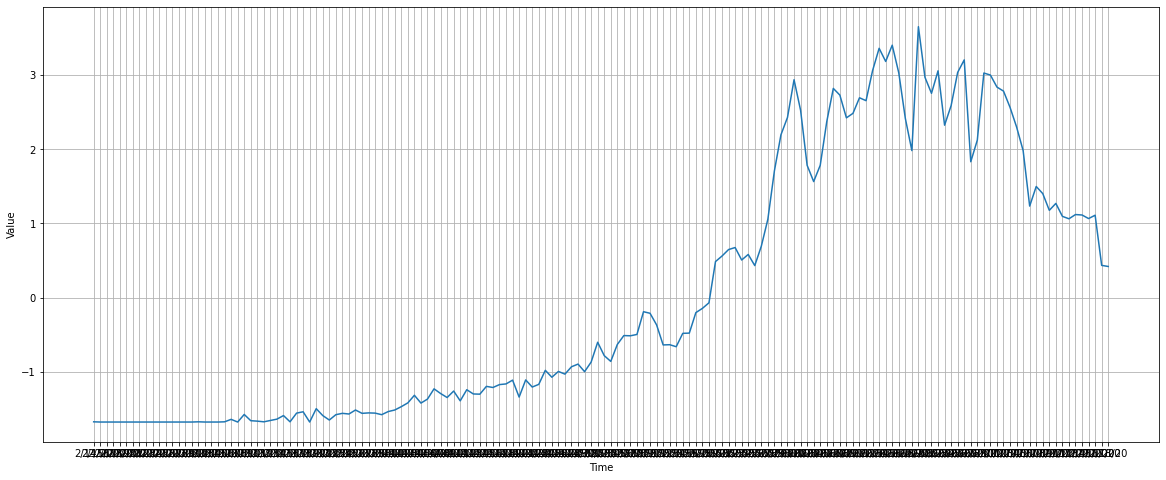

In [246]:
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(20, 8))
plot_series(time, series)

In [247]:
split_time = int(0.8 * series.shape[0])
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 10
batch_size = 5
shuffle_buffer_size = 500

In [248]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [249]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### The model

In [250]:
import tensorflow as tf
import numpy as np


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size = 64
#batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(next(iter(train_set.take(5))))
# print(x_train.shape)

model = tf.keras.models.Sequential([
  
  tf.keras.layers.Conv1D(filters=50, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.LeakyReLU()
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

x = model.evaluate(test_set)


Epoch 1/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 0s 18ms/step - loss: 1.4142 - mae: 1.4142 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 1.7783e-08
Epoch 7/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 1.9953e-08
Epoch 8/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 2.2387e-08
Epoch 9/100
23/23 [==============================] - 0s 19ms/step - loss: 1.4142 - mae: 1.4142 - lr: 2.5

(5.655877526068171e-09,
 0.0015757960743081156,
 0.26761375814676286,
 1.4688120290637017)

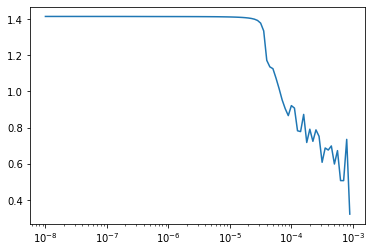

In [251]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis()

In [252]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

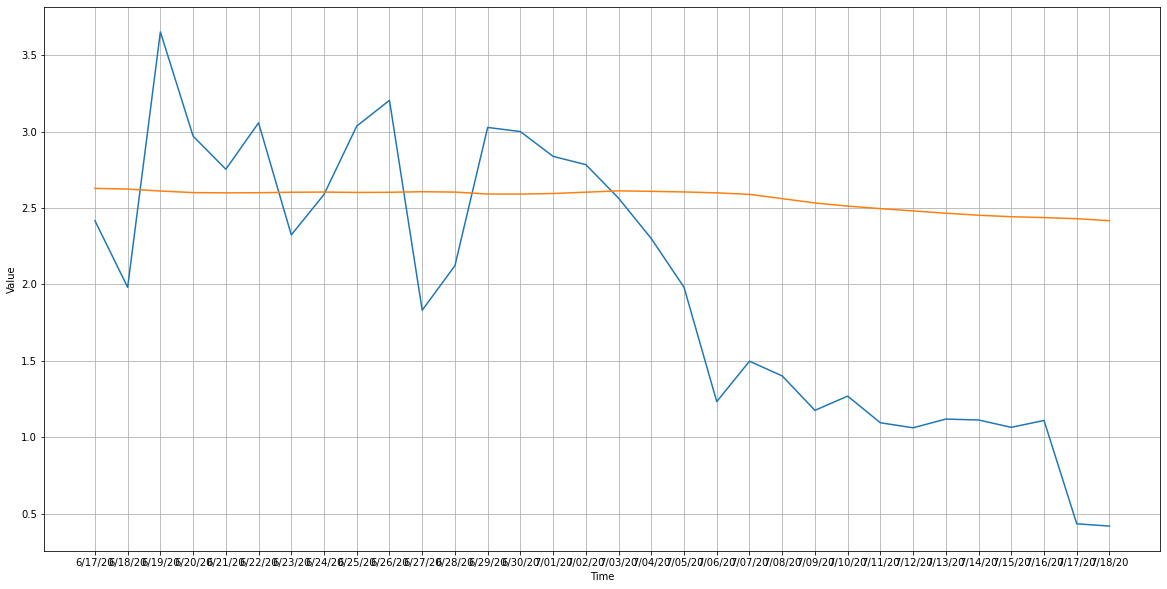

In [253]:
plt.figure(figsize=(20, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

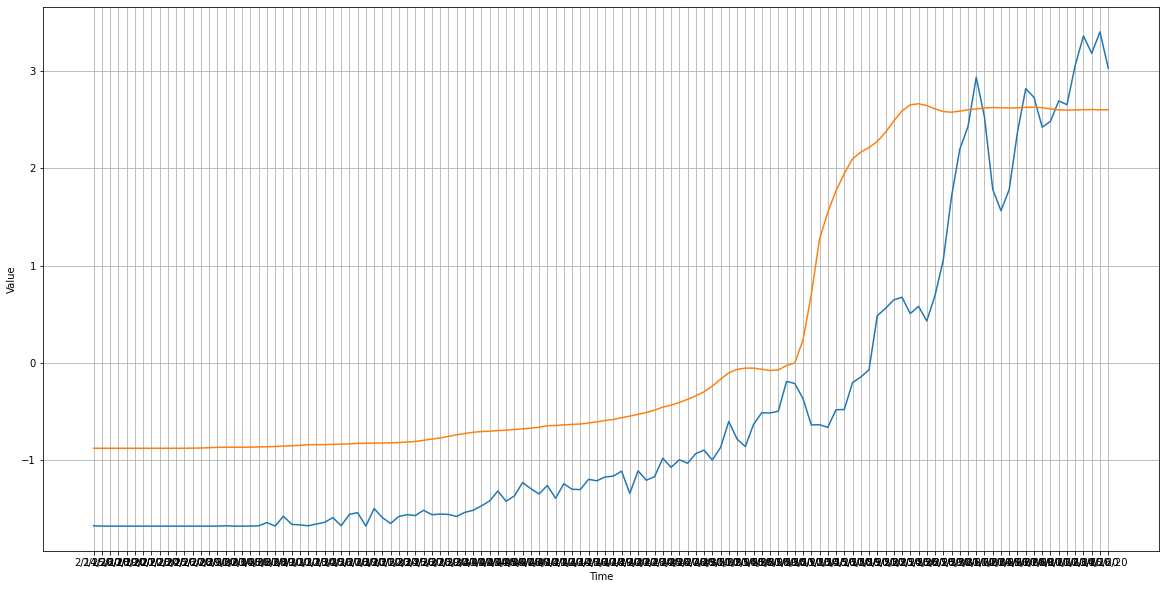

In [254]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[ : split_time, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_train, x_train)
plot_series(time_train, rnn_forecast)